# PSF Gaussian Fitting demo

[Colab Link](https://colab.research.google.com/github/casangi/astroviper/blob/main/docs/core_tutorials/imaging/psf_fitting.ipynb)


This notebook demonstrates PSF fitting to a 2-D gaussian beam. The fitting code was adopted from https://github.com/casangi/cngi_prototype/blob/master/cngi/image/fit_gaussian.py . This demo uses a CASA PSF image and converted into an XRadio image format, then fitting is performed. Simple numerical comparison with the beam parameters stored in the input CASA image are also made.

---
## Pseudo Code

xds_image

```
psf_gaussian_fit(xds_image, pix_window, sampling)
   xds_new =  xds.copy
   delta = (l_delta_xds_image, m_delta_xds_image)
   
   psf_gaussian_core(xds_image, window, delta)
      # loop over time, chan, pol coordinates
      for time in xds
         for chan in xds
             for pol in xds
               interpolated_image_to_fit = interpn(xds,pix_window, sampling) 
               fit_param = minimize(beam_chi2, inpterpolated_image_to_fit)

               beam_param(time, chan, pol ) = fit_param
   xds_new.BEAM.data = beam_param
   return xds_new

```

---
## API

In [1]:
# import psf gaussian fit function
from astroviper.core.image_analysis.psf_gaussian_fit import psf_gaussian_fit
psf_gaussian_fit?

Signature:
psf_gaussian_fit(
    xds: xarray.core.dataset.Dataset,
    dv: str = 'POINT_SPREAD_FUNCTION',
    npix_window: tuple = (41, 41),
    sampling: tuple = (55, 55),
    cutoff: float = 0.35,
)
Docstring:
fit 2D gaussian to psf

Parameters
----------
xds : xarray.Dataset
    The input data cube.
dv : str
    The data variable to fit. Default is 'POINT_SPREAD_FUNCTION'.
npix_window : tuple
    The size of the fitting window in pixels.
sampling : tuple
    The sampling of the fitting grid in pixels.
cutoff : float
    The cutoff value for the fitting.

Returns
-------
xds : xarray.Dataset
    The image with the fitted parameters added.
    The l and m coordinates of the input data are assumed to be in radians.
    The units of beam size (major and minor) and position angle are in radians.

Notes:
-----
- Returns NaN values for beam parameters if the fitting fails
- L-BFGS-B optimization method is used with bounds on parameters
File:      ~/Dropbox/astroviper/src/astroviper/core/im

---
## Notes
* The beam parameters are given in radians
* The specified window is cenentered on the peak of the image
* Sidelobes are checked and excluded within the specified window and determine the final fitting window 
* This implementation uses L-BFGS for minimization algorithm while the CASA C++ implentation uses Levenberg-Marquradt method.
* Also the following two types of re-tries of fitting that the CASA implementation has not been implmeneted.
  * No retries of fitting by modifying initial rotation angle  when the fit fails
  * No retries of fitting by increasing fitting region (by decreasing cutoff = cutoff/1.5) when the fit fails

## Install AstroVIPER

Skip this cell if you don't want to install the latest version of AstroVIPER.

In [2]:
from importlib.metadata import version
import os

try:
    os.system("pip install --upgrade astroviper")
    os.system("pip install python-casacore")
    import astroviper

    print("Using astroviper version", version("astroviper"))

except ImportError as exc:
    print(f"Could not import astroviper: {exc}")

Using astroviper version 0.0.30


## Download Data

Download the test CASA PSF image and convert to the XRADIO image

In [3]:
# use toolviper
import toolviper
toolviper.utils.data.update()


[2026-01-16 09:08:48,712]  WARNING    viperlog:  File exists: /Users/jsteeb/miniforge3/envs/timg/lib/python3.13/site-packages/toolviper/utils/data/.cloudflare 
[2026-01-16 09:08:48,713]     INFO    viperlog:  Updating file metadata information ...  


Output()

In [4]:
from toolviper.utils.data import download
download(file="twhya_selfcal_11chans_lsrk_robust_0.5_niter_0.psf")

[2026-01-16 09:08:48,995]     INFO    viperlog:  Downloading from [cloudflare] .... 


 Download List                                      
 ─────────────────────────────────────────────────── 
  twhya_selfcal_11chans_lsrk_robust_0.5_niter_0.psf

[2026-01-16 09:08:48,998]     INFO    viperlog:  File exists: twhya_selfcal_11chans_lsrk_robust_0.5_niter_0.psf 


Output()

## Import the data and run PSF gaussian fit 

### Import the CASA image to an XRADIO image data

In [5]:
from xradio.image import open_image
xds = open_image(store='twhya_selfcal_11chans_lsrk_robust_0.5_niter_0.psf', chunks={"l":25, "m":25, "frequency":4} )
xds

Successful readonly open of default-locked table twhya_selfcal_11chans_lsrk_robust_0.5_niter_0.psf: 1 columns, 1 rows


<xarray.Dataset> Size: 4MB
Dimensions:                                (time: 1, frequency: 11,
                                            polarization: 1, l: 250, m: 250,
                                            beam_params_label: 3)
Coordinates:
  * time                                   (time) float64 8B 5.625e+04
  * frequency                              (frequency) float64 88B 3.728e+11 ...
  * polarization                           (polarization) <U1 4B 'I'
  * l                                      (l) float64 2kB 6.06e-05 ... -6.01...
  * m                                      (m) float64 2kB -6.06e-05 ... 6.01...
  * beam_params_label                      (beam_params_label) <U5 60B 'major...
    velocity                               (frequency) float64 88B 2.454e+03 ...
    right_ascension                        (l, m) float64 500kB 1.409 ... 1.409
    declination                            (l, m) float64 500kB -0.6364 ... -...
Data variables:
    POINT_SPREAD_FUNCTION                  (time, frequency, polarization, l, m) float32 3MB dask.array<chunksize=(1, 4, 1, 25, 25), meta=np.ndarray>
    BEAM_FIT_PARAMS_POINT_SPREAD_FUNCTION  (time, frequency, polarization, beam_params_label) float64 264B dask.array<chunksize=(1, 11, 1, 3), meta=np.ndarray>
Attributes:
    coordinate_system_info:  {'reference_direction': {'attrs': {'frame': 'fk5...
    type:                    image_dataset
    data_groups:             {}

### Examine data content

In [6]:
xds.POINT_SPREAD_FUNCTION

<xarray.DataArray 'POINT_SPREAD_FUNCTION' (time: 1, frequency: 11,
                                           polarization: 1, l: 250, m: 250)> Size: 3MB
dask.array<transpose, shape=(1, 11, 1, 250, 250), dtype=float32, chunksize=(1, 4, 1, 25, 25), chunktype=numpy.ndarray>
Coordinates:
  * time             (time) float64 8B 5.625e+04
  * frequency        (frequency) float64 88B 3.728e+11 3.728e+11 ... 3.728e+11
  * polarization     (polarization) <U1 4B 'I'
  * l                (l) float64 2kB 6.06e-05 6.012e-05 ... -6.012e-05
  * m                (m) float64 2kB -6.06e-05 -6.012e-05 ... 6.012e-05
    velocity         (frequency) float64 88B 2.454e+03 1.964e+03 ... -2.454e+03
    right_ascension  (l, m) float64 500kB 1.409 1.409 1.409 ... 1.409 1.409
    declination      (l, m) float64 500kB -0.6364 -0.6364 ... -0.6363 -0.6363
Attributes:
    type:             point_spread_function
    units:            
    telescope:        {'name': 'ALMA', 'direction': {'attrs': {'coordinate_sy...
    observer:         cqi
    obsdate:          {'attrs': {'units': 'd', 'scale': 'utc', 'format': 'mjd...
    pointing_center:  {'attrs': {'frame': 'fk5', 'type': 'sky_coord', 'units'...
    object_name:      J0522-364
    user:             {'INSTRUME': 'ALMA', 'distance': 0.0, 'mpiprocs': 1, 'c...
    description:      None
    beam_fit_params:  BEAM_FIT_PARAMS_POINT_SPREAD_FUNCTION

In [7]:
xds.BEAM_FIT_PARAMS_POINT_SPREAD_FUNCTION

<xarray.DataArray 'BEAM_FIT_PARAMS_POINT_SPREAD_FUNCTION' (time: 1,
                                                           frequency: 11,
                                                           polarization: 1,
                                                           beam_params_label: 3)> Size: 264B
dask.array<array, shape=(1, 11, 1, 3), dtype=float64, chunksize=(1, 11, 1, 3), chunktype=numpy.ndarray>
Coordinates:
  * time               (time) float64 8B 5.625e+04
  * frequency          (frequency) float64 88B 3.728e+11 3.728e+11 ... 3.728e+11
  * polarization       (polarization) <U1 4B 'I'
  * beam_params_label  (beam_params_label) <U5 60B 'major' 'minor' 'pa'
    velocity           (frequency) float64 88B 2.454e+03 ... -2.454e+03
Attributes:
    units:    rad
    type:     beam_fit_params_point_spread_function

### Run gaussian fit on the PSF image

The psf_gaussian_fit function will create a copy of xds and add fitted beam parameters to BEAM data variable.

In [8]:
# run psf fitting 
# use sampling comparable to one used in CASA (3001 points for x-y matrix)
import time
start_tm = time.time()
res_xds = psf_gaussian_fit(xds,npix_window=(41,41), sampling=(55,55))
print(f"time for fitting: {time.time()-start_tm}s")

peak_x, peak_y= 125 125
maximum sidelobe level:  0.40454093


/Users/jsteeb/Dropbox/astroviper/src/astroviper/core/image_analysis/psf_gaussian_fit.py:335: NumbaWarning: Code running in object mode won't allow parallel execution despite nogil=True.
  with objmode(res_x="f8[:]"):  # return type annotation


time for fitting: 4.393655061721802s


##　Results

In [9]:
# the fitted beam parameters (Bmaj, Bmin, PA) are stored in radians in BEAM data variable 
res_xds['BEAM_FIT_PARAMS_POINT_SPREAD_FUNCTION'].compute()

<xarray.DataArray 'BEAM_FIT_PARAMS_POINT_SPREAD_FUNCTION' (time: 1,
                                                           frequency: 11,
                                                           polarization: 1,
                                                           beam_params_label: 3)> Size: 264B
array([[[[2.73687274e-06, 2.21337083e-06, 5.36940552e-01]],

        [[2.71038870e-06, 2.16752399e-06, 5.68386276e-01]],

        [[2.71038598e-06, 2.16752134e-06, 5.68386725e-01]],

        [[2.71037999e-06, 2.16751841e-06, 5.68385198e-01]],

        [[2.71064795e-06, 2.16713985e-06, 5.68251728e-01]],

        [[2.71064455e-06, 2.16713533e-06, 5.68249434e-01]],

        [[2.71063991e-06, 2.16712925e-06, 5.68247802e-01]],

        [[2.71063635e-06, 2.16712337e-06, 5.68247445e-01]],

        [[2.71063273e-06, 2.16711932e-06, 5.68247287e-01]],

        [[2.71063084e-06, 2.16711726e-06, 5.68247163e-01]],

        [[2.71062742e-06, 2.16711487e-06, 5.68250158e-01]]]])
Coordinates:
  * time               (time) float64 8B 5.625e+04
  * frequency          (frequency) float64 88B 3.728e+11 3.728e+11 ... 3.728e+11
  * polarization       (polarization) <U1 4B 'I'
  * beam_params_label  (beam_params_label) <U5 60B 'major' 'minor' 'pa'
    velocity           (frequency) float64 88B 2.454e+03 ... -2.454e+03
Attributes:
    units:    rad
    type:     beam_fit_params_point_spread_function

### Plot the input image with the original CASA beam stored in the image for reference

In [10]:
# select first frequency channel
data_sel = {'time':[0], 'polarization':[0], 'frequency':[0]}

CASA beam parameters: bmaj=2.6214203167700385e-06,bmin=2.1205892648113387e-06, bpa=30.86190414428711


'rad'

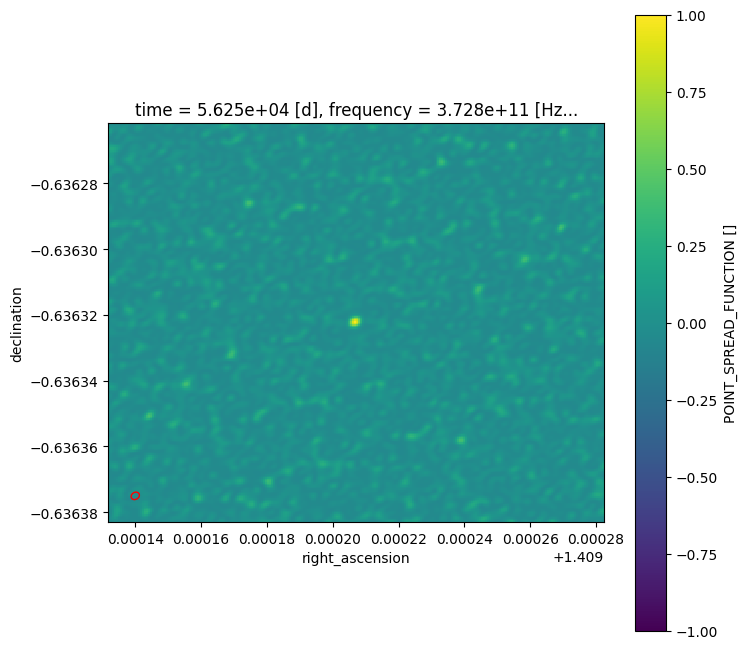

In [11]:
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np

data1 = xds.POINT_SPREAD_FUNCTION.isel(data_sel).squeeze().T
#
fig, ax = plt.subplots(figsize=(8,8))
data1.plot.pcolormesh(x='right_ascension', y='declination', ax=ax, cmap='viridis', add_colorbar=True)
bmaj = xds.BEAM_FIT_PARAMS_POINT_SPREAD_FUNCTION.isel(data_sel).data.compute()[0,0,0][0]
bmin = xds.BEAM_FIT_PARAMS_POINT_SPREAD_FUNCTION.isel(data_sel).data.compute()[0,0,0][1]
bpa = np.rad2deg(xds.BEAM_FIT_PARAMS_POINT_SPREAD_FUNCTION.isel(data_sel).data.compute()[0,0,0][2])
print(f'CASA beam parameters: bmaj={bmaj},bmin={bmin}, bpa={bpa}')
from matplotlib.patches import Ellipse

beam = Ellipse(
    (1.40914,-0.636375),
    width=bmaj,
    height=bmin,
    angle=bpa,
    color='red',
    lw=1,
    fill=False,
    zorder=10 # Ensure the ellipse is drawn on top
)
ax.add_patch(beam)
ax.set_aspect('equal', adjustable='box')
xds.BEAM_FIT_PARAMS_POINT_SPREAD_FUNCTION.attrs['units']

### Compare the fitting result with one provided in the input image

In [12]:
# Generate 2D gaussian using xds BEAM data variable 
def psf_model(xds, data_sel, beam_param):
    wx, wy, rot = beam_param
    # uncomment the line below for a quick check on the beam parameter
    #print(f"bmaj:{wx}, bmin:{wy}, pa:{rot}")
    l = xds.POINT_SPREAD_FUNCTION.isel(data_sel).l.data
    m = xds.POINT_SPREAD_FUNCTION.isel(data_sel).m.data
    X, Y = np.meshgrid(l,m)
    # adjust rotation angle to one measured from +x axis
    rot = -(np.pi/2 - rot)
    xp = X*np.cos(rot) + Y*np.sin(rot)
    yp = X*np.sin(rot) - Y*np.cos(rot)
    gaussian = 1.0 * np.exp(-(((xp) / wx) ** 2 + ((yp) / wy) ** 2) / 2.0)
    return gaussian

In [13]:
# psf model based on the CASA beam parameter
casa_model = psf_model(xds, data_sel, xds.BEAM_FIT_PARAMS_POINT_SPREAD_FUNCTION.isel(data_sel).data.compute().squeeze())

In [14]:
# new fit result
model = psf_model(xds, data_sel,res_xds.BEAM_FIT_PARAMS_POINT_SPREAD_FUNCTION.isel(data_sel).data.compute().squeeze())

In [15]:
# extract beam parameters (without data selection)
beam_param = res_xds.BEAM_FIT_PARAMS_POINT_SPREAD_FUNCTION.data.compute()
bmajs = beam_param[:,:,:].squeeze().T[0]
bmins = beam_param[:,:,:].squeeze().T[1]
pas = beam_param[:,:,:].squeeze().T[2]
casa_beam_param = xds.BEAM_FIT_PARAMS_POINT_SPREAD_FUNCTION.data.compute()
casa_bmajs = casa_beam_param[:,:,:].squeeze().T[0]
casa_bmins = casa_beam_param[:,:,:].squeeze().T[1]
casa_pas = casa_beam_param[:,:,:].squeeze().T[2]

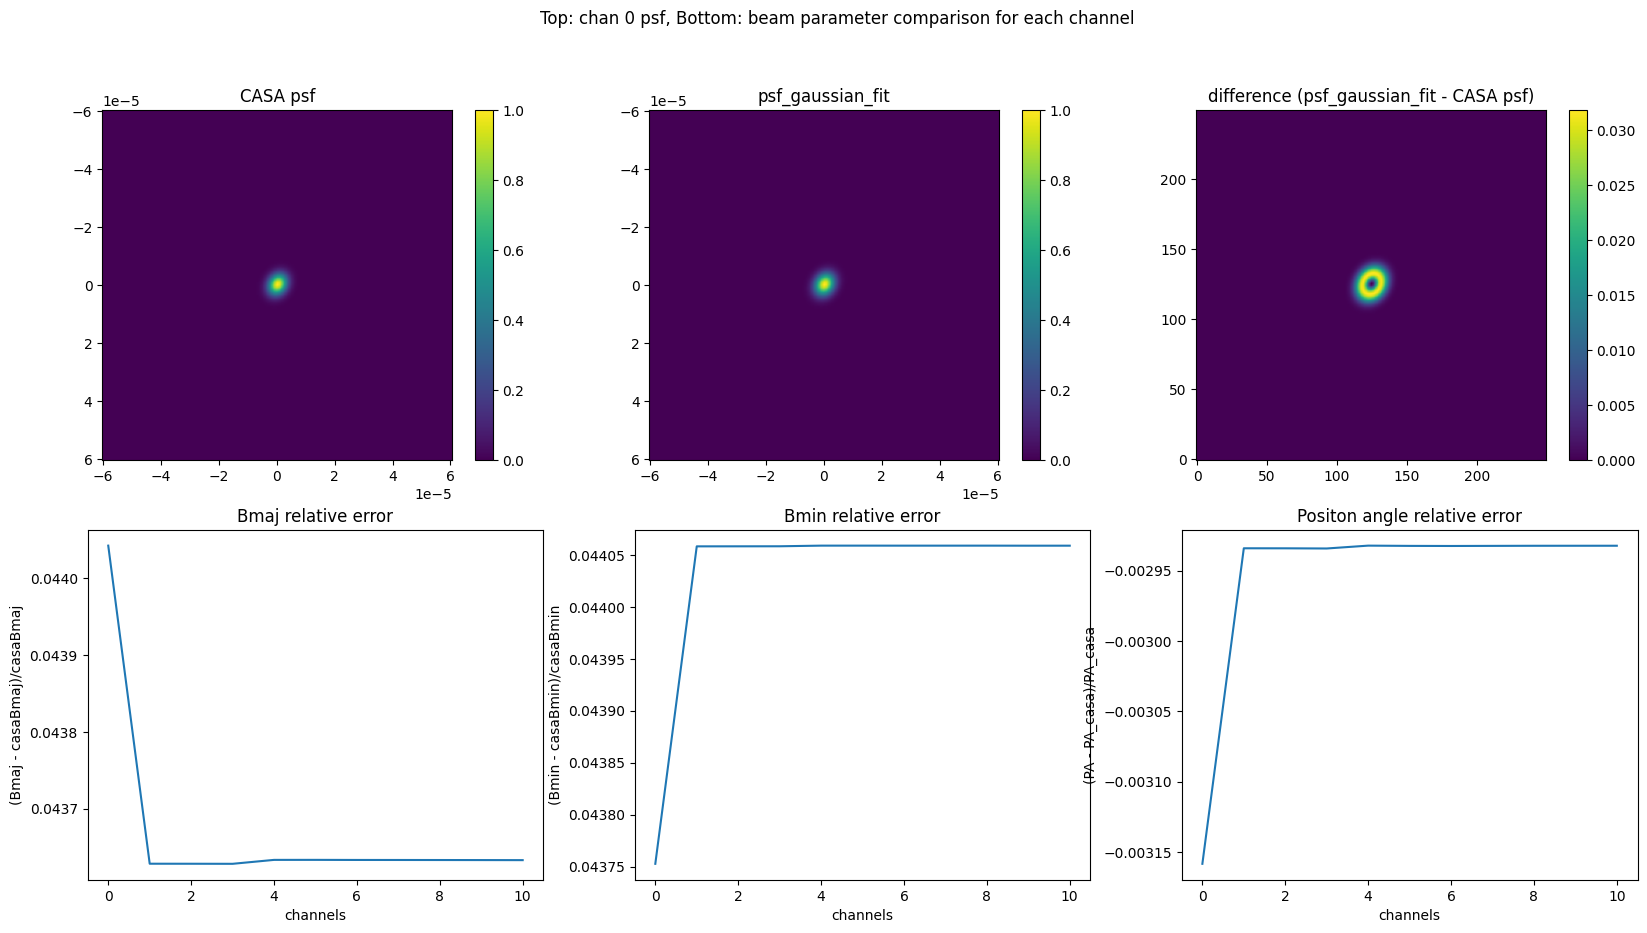

In [16]:
# plot beam images
fig, axes = plt.subplots(2, 3, figsize=(20, 10))
l = xds.POINT_SPREAD_FUNCTION.isel(data_sel).l.data
m = xds.POINT_SPREAD_FUNCTION.isel(data_sel).m.data
extent=(l[-1], l[0], m[-1], m[0])
im1 = axes[0, 0].imshow(casa_model, extent=extent, origin='lower', cmap='viridis')
plt.colorbar(im1, ax=axes[0,0])
axes[0, 0].set_title("CASA psf")
im2 = axes[0, 1].imshow(model, extent=extent, origin='lower', cmap='viridis')
plt.colorbar(im2, ax=axes[0,1])
axes[0,1].set_title("psf_gaussian_fit")
im3 = axes[0,2].imshow( (model - casa_model), origin='lower', cmap='viridis')
axes[0,2].set_title("difference (psf_gaussian_fit - CASA psf)")
plt.colorbar(im3, ax=axes[0,2])
# plot beam parameters across channels
chans = np.arange(beam_param.shape[1])
axes[1,0].plot(chans, (bmajs - casa_bmajs)/bmaj)
axes[1,0].set_ylabel("(Bmaj - casaBmaj)/casaBmaj")
axes[1,0].set_xlabel("channels")
axes[1,0].set_title("Bmaj relative error")
axes[1,1].plot(chans, (bmins - casa_bmins)/casa_bmins)
axes[1,1].set_ylabel("(Bmin - casaBmin)/casaBmin")
axes[1,1].set_xlabel("channels")
axes[1,1].set_title("Bmin relative error")
#axes[1,2].plot(chans, (pas - casa_pas)/casa_pas)
axes[1,2].set_ylabel("(PA - PA_casa)/PA_casa")
axes[1,2].set_xlabel("channels")
axes[1,2].set_title("Positon angle relative error")
axes[1,2].plot(chans, (pas - casa_pas)/casa_pas)
fig.suptitle("Top: chan 0 psf, Bottom: beam parameter comparison for each channel")
plt.show()